# ЛР 3 Каргаполов Денис Андреевич 1.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

# генератор изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### <center> _Подготовка данных_

In [4]:
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '../content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

FileNotFoundError: [Errno 2] No such file or directory: '../content/bus/'

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Удаление файла .DS_Store из списка, если он есть (скрытый файл создаваемый macOS)
if '.DS_Store' in CLASS_LIST:
    CLASS_LIST.remove('.DS_Store')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса
for cls in CLASS_LIST:
    files = os.listdir(f'{IMAGE_PATH}{cls}/')[:5]
    print(cls, ':', files)

Входящий : ['04354.jpg', '02725.jpg', '00132.jpg', '00654.jpg', '06225.jpg']
Выходящий : ['00132.jpg', '00654.jpg', '02043.jpg', '02057.jpg', '00640.jpg']


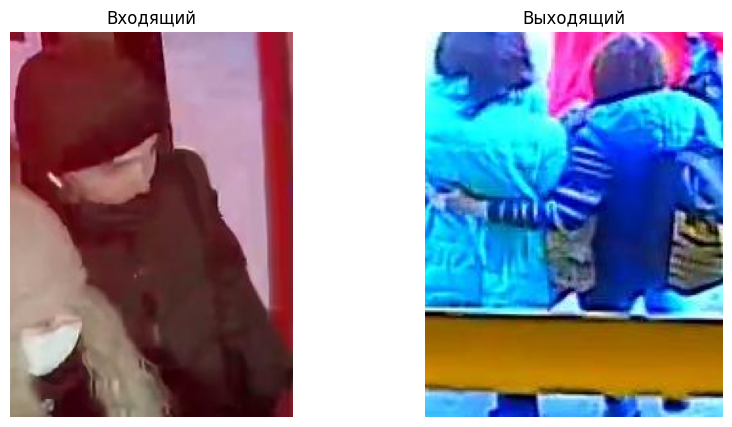

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
# Cписок путей к файлам картинок
data_files = []
# Список меток классов, соответствующих файлам
data_labels = []

for class_label in range(CLASS_COUNT):
    class_name = CLASS_LIST[class_label]
    class_path = IMAGE_PATH + class_name
    class_files = os.listdir(class_path)
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [8]:
# Задание высоты и ширины загружаемых изображений
IMG_HEIGHT = 32
IMG_WIDTH = 64
BATCH_SIZE_1 = 128
BATCH_SIZE_2 = 32

# Пустой список для данных изображений
data_images = []

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_HEIGHT, IMG_WIDTH)).convert("L")
    img_np = np.array(img)
    data_images.append(img_np) 

x_data = np.array(data_images).reshape(-1,64,32,1)
y_data = np.array(data_labels)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Создание генератора изображений
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Создание генератора данных
train_generator = datagen.flow(x_data, y_data, batch_size=BATCH_SIZE_1)

# Создание генератора данных для валидационного набора
val_generator = datagen.flow(x_val, y_val, batch_size=BATCH_SIZE_2)




In [9]:
# задаем желаемый размер изображениям

img_height = 32
img_width = 64
chanels = 1

# вкодные данные
input_shape = (img_height, img_width, chanels)

### <center> _Реализация и обучение модели_

In [10]:
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(input_shape)),
    BatchNormalization(),

    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    BatchNormalization(),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='relu'),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.1),
    
    Dense(2, activation='softmax')
])  

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 16, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 16, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,106 (1.98 MB)

 Trainable params: 518,066 (1.98 MB)

 Non-trainable params: 1,040 (4.06 KB)

Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.3837 - loss: 1.0333 - val_accuracy: 0.2801 - val_loss: 0.7195
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.5866 - loss: 0.7163 - val_accuracy: 0.7199 - val_loss: 0.6515
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.6658 - loss: 0.6399 - val_accuracy: 0.7199 - val_loss: 0.6075
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.6841 - loss: 0.6136 - val_accuracy: 0.7199 - val_loss: 0.5902
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6997 - loss: 0.5984 - val_accuracy: 0.7199 - val_loss: 0.5848
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7019 - loss: 0.5987 - val_accuracy: 0.7199 - val_loss: 0.5815
Epoch 7/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7156 - loss: 0.5754 - val_accuracy: 0.7221 - val_loss: 0.5620
Epoch 8/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7251 - loss: 0.5652 - val_accuracy: 0.

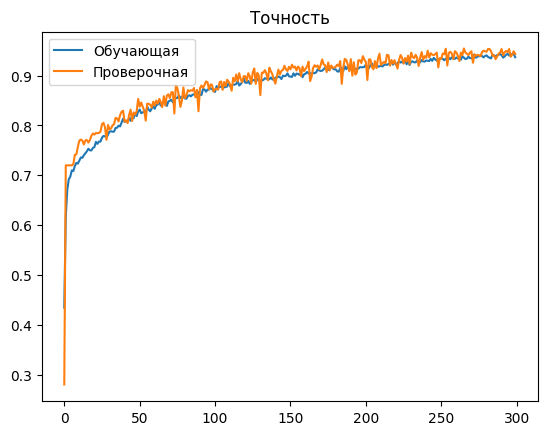

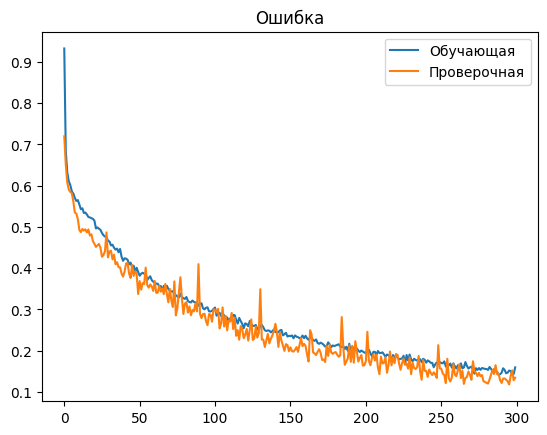

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

store = model.fit(train_generator,
                  epochs=300,
                  validation_data=val_generator,
                  verbose=1)


plt.plot(store.history['accuracy'], label='Обучающая')
plt.plot(store.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')
plt.show()
plt.plot(store.history['loss'], label='Обучающая')
plt.plot(store.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()